# ResNet（Residual Network）

ResNet是由微软研究院的Kaiming He等人在2015年提出的深度卷积神经网络架构，它在ImageNet和COCO等计算机视觉任务中取得了显著的成绩。ResNet的核心思想是引入了**残差学习（Residual Learning）**，解决了深度神经网络中的**梯度消失**和**退化问题**，使得网络可以训练得更深、更高效。

---

## 1. ResNet的特点

- **残差块（Residual Block）**：ResNet的核心是残差块，它引入了“跳跃连接”（Skip Connection）或“短路连接”（Shortcut Connection）。残差块的输入直接与输出相加，形成一个残差映射 $F(x) = H(x) - x$，其中 $H(x)$ 是目标映射，$x$ 是输入。通过这种方式，网络可以学习残差 $F(x)$ 而不是直接学习 $H(x)$。
<img src="img/Residual_Block.png">
- **深度网络**：ResNet可以构建非常深的网络（如ResNet-152），而不会出现梯度消失或退化问题。
- **恒等映射**：跳跃连接允许网络在某些层中直接传递输入，从而简化了训练过程。

---

## 2. ResNet的优势

- **解决梯度消失问题**：跳跃连接使得梯度可以直接传递到前面的层，缓解了深度网络中的梯度消失问题。
- **解决退化问题**：即使网络很深，ResNet的性能也不会随着层数的增加而显著下降。
- **高效训练**：残差学习使得网络更容易优化，训练速度更快。
- **可扩展性**：ResNet可以扩展到非常深的网络（如ResNet-101、ResNet-152等），同时保持高性能。
- **通用性强**：ResNet不仅在图像分类任务中表现优异，还在目标检测、语义分割等任务中取得了显著效果。

---

## 3. ResNet的劣势

- **计算成本高**：虽然ResNet解决了深度网络的训练问题，但非常深的网络（如ResNet-152）仍然需要大量的计算资源。
- **参数较多**：深层的ResNet模型参数较多，可能在某些资源受限的场景中不适用。
- **过拟合风险**：对于较小的数据集，过深的ResNet可能会导致过拟合。

---

## 4. ResNet的架构

ResNet的基本单元是**残差块**，其结构如下：

- **普通残差块**：由两个3x3卷积层组成，输入通过跳跃连接直接加到输出上。
- **瓶颈残差块**：为了减少计算量，ResNet引入了瓶颈结构，由1x1、3x3、1x1卷积层组成，其中1x1卷积层用于降维和升维。

ResNet的主要版本包括：

- **ResNet-18/34**：使用普通残差块。
- **ResNet-50/101/152**：使用瓶颈残差块。

### 残差块的数学表达

对于输入 $x$，残差块的输出为：
$$
y = F(x, W_{i}) + x
$$
其中 $F(x, W_{i})$ 是残差映射，$x$ 是跳跃连接的输入。

---

## 5. ResNet的应用

ResNet广泛应用于各种计算机视觉任务，包括：

- **图像分类**：在ImageNet等数据集上取得了优异的分类性能。
- **目标检测**：如Faster R-CNN、Mask R-CNN等检测框架中使用了ResNet作为骨干网络。
- **语义分割**：ResNet在分割任务中也被广泛使用。
- **迁移学习**：ResNet的预训练模型常用于其他任务的迁移学习。

---

## 6. ResNet与其他网络的对比示意图

<img src="img/Comparison.png">

---

## 总结

ResNet通过引入残差学习和跳跃连接，解决了深度神经网络中的梯度消失和退化问题，使得网络可以训练得更深、更高效。虽然它在计算成本和参数量上有一定劣势，但其在计算机视觉任务中的表现和通用性使其成为深度学习领域的重要里程碑。

---

## ResNet 的代码实现

### 1. 必要库的导入

In [1]:
import os
import sys
import torch
from torch import functional as F
from PIL import Image
import numpy as np
from torchsummary import summary
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 获取当前文件的父目录
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'),'..'))
# 如果父目录不在 sys.path中，则添加
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import utils
    
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.mps.is_available()
                      else 'cpu')
print(torch.__version__)
print(device)

2.6.0
mps


### 2.导入数据库并转换为DataLoader格式

在这一部分中，我们使用torchvision.transforms 仿照原论文对图像进行预处理：
- `Resize` 和 `CenterCrop`：调整图像大小以匹配模型输入。
- `ToTensor`：将图像转换为张量。
- `Normalize`：对像素值进行归一化，有助于模型更快收敛。
- 在训练集中用 `RandomHorizontalFlip`使得图像随机水平翻转，增强图像

In [ ]:
# 对于ImageNet数据集，我们使用ImageNet的均值和标准差来归一化图像。
transform = {'train':transforms.Compose([
    transforms.Resize(256),                    # 缩放图像，使得最短边为256像素
    transforms.RandomCrop(224),                # 中心裁剪224x224
    transforms.RandomHorizontalFlip(),         # 随机水平翻转
    transforms.ToTensor(),                     # 转换为Tensor，并缩放到[0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # 按ImageNet均值和标准差归一化
                         std=[0.229, 0.224, 0.225])]),
             'val':transforms.Compose([
    transforms.Resize(256),                    # 缩放图像，使得最短边为256像素
    transforms.CenterCrop(224),                # 中心裁剪224x224
    transforms.ToTensor(),                     # 转换为Tensor，并缩放到[0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # 按ImageNet均值和标准差归一化
                         std=[0.229, 0.224, 0.225])])}


In [ ]:
# 读取验证集的标签
val_labels = {}
with open('../Datasets/tiny-imagenet-200/val/val_annotations.txt') as f:
    for line in f:
        parts = line.strip().split('\t')
        filename, label = parts[0], parts[1]
        val_labels[filename] = label
print(val_labels['val_0.JPEG'])

# 首先将训练数据集加载到DataLoader中
ImageNet_train = datasets.ImageFolder(root='../Datasets/tiny-imagenet-200/train',transform=transform['train'])
ImageNet_train_iter = DataLoader(ImageNet_train,batch_size=64,shuffle=True,num_workers=0)

# 自定义验证集数据集
class TinyImageNetValDataset(Dataset):
    def __init__(self, img_dir, val_labels, transform=None):
        self.img_dir = img_dir
        self.img_dict = val_labels
        self.transform = transform
        self.classes = sorted(list(set(self.img_dict.values())))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.img_list = list(self.img_dict.keys())

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.img_dict[img_name]]

        if self.transform:
            image = self.transform(image)
        return image, label
    
ImageNet_val = TinyImageNetValDataset(
    img_dir='../Datasets/tiny-imagenet-200/val/images',
    val_labels=val_labels,
    transform=transform['val'])
ImageNet_val_iter = DataLoader(ImageNet_val, batch_size=64, shuffle=False, num_workers=0)

# 尝试输出两个DataLoader中的第一批张量的形状
img_train = next(iter(ImageNet_train_iter))
print(len(img_train))
print(img_train[0].shape)
print(img_train[1].shape)
print(img_train[1])

img_val = next(iter(ImageNet_val_iter))
print(len(img_val))
print(img_val[0].shape)
print(img_val[1].shape)
print(img_val[1])

### 3. 尝试构建一个最基本的ResNet块
ResNet显然同样是由多个相似的残差块构成的，我们先定义好一个最基本的残差块，即一个包含两个卷积层的残差块。

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels,stride=1):
        super(BasicBlock, self).__init__()
        
        # 第一个卷积层
        self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True))
        
        # 第二个卷积层
        self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels))
        
        # 跳跃连接
        self.shortcut = nn.Sequential()
        # 如果输入通道数和输出通道数不同，则需要添加卷积层和BN层以改变x的形状（即通道数和像素数）
        if stride != 1 or in_channels != out_channels: 
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        # 残差映射
        out = self.conv1(x)
        out = self.conv2(out)
        # 跳跃连接
        out += self.shortcut(x)
        out = self.relu(out)
        
        return out

**卷积层：** 使用两个3x3卷积层，每个卷积层后接批量归一化（BatchNorm）和ReLU激活函数。

**跳跃连接：** 如果输入和输出的通道数或尺寸不一致（例如通过步幅 stride 调整大小），则使用1x1卷积调整输入的通道数和尺寸，以便与输出相加。

**残差映射：** 对于每个残差块，计算残差映射 $F(x)$，然后将输入 $x$ 通过跳跃连接加到输出上。

### 4. 开始用ResNet的基本块来搭建整个ResNet网络

接下来，我们可以通过堆叠多个BasicBlock来构建ResNet模型。ResNet模型通常由多个“阶段”（stage）组成，每个阶段包含多个ResNet块，且每个阶段的特征图尺寸会逐渐减小，通道数会逐渐增加。

以下是一个简单的ResNet-18模型的实现：

In [3]:
from sympy import Basic


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super().__init__()
        
        self.in_channels = 64 # 在后面的_make_layer函数中会用到
        
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
        self.main_layers = nn.Sequential(
            self._make_layer(block, 64, num_blocks[0], stride=1),
            self._make_layer(block, 128, num_blocks[1], stride=2),
            self._make_layer(block, 256, num_blocks[2], stride=2),
            self._make_layer(block, 512, num_blocks[3], stride=2)
            )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self,block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.main_layers(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18(num_classes=200):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

model = resnet18()
summary(model,(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### 解释
`_make_layer`函数用于创建一个由多个ResNet块组成的层。每个层的第一个块的步幅（stride）可以大于1，用于下采样特征图。

`num_blocks`列表指定了每个层中ResNet块的数量。例如，[2, 2, 2, 2]表示每个层有2个ResNet块，这是ResNet-18的结构。

`pre_layers`是ResNet的预处理层，包括卷积层、BN层、ReLU激活函数层。

### （选读）ResNet基本块的变体：Bottleneck ResNet Block

在ResNet-50、ResNet-101和ResNet-152中，作者发现这种基本块的效率较低，因此提出了一种新的Bottleneck ResNet Block

####  Bottleneck Block 的结构
Bottleneck Block 是 ResNet 中的一种基本构建单元，其核心思想是通过 降维-升维 的方式减少计算量。它的结构通常由三个卷积层组成，具体如下：

1. **1x1 卷积层：**
- 作用：降维，减少通道数。例如，将输入特征图的通道数从 256 减少到 64。
- 目的：减少后续卷积层的计算量。

2. **3x3 卷积层：**
- 作用：提取空间特征。这是核心卷积层，用于捕捉图像的局部特征。
- 目的：提取空间特征，提高模型的鲁棒性。

3. **1x1 卷积层：**
- 作用：升维，恢复通道数。例如，将通道数从 64 恢复到 256。
- 目的：恢复特征图的维度，以便与输入特征图相加（残差连接）。

#### 为什么叫 Bottleneck？
Bottleneck Block 的名字来源于其结构设计：通过 1x1 卷积层先将特征图的通道数减少（“瓶颈”），然后再通过 3x3 卷积层提取特征，最后再通过 1x1 卷积层恢复通道数。这种设计类似于一个“瓶颈”，先压缩再扩展。

#### 优点：
- 减少计算量：3x3 卷积层的输入通道数减少，计算量大幅降低。
- 减少参数数量：1x1 卷积层可以显著减少参数量。
- 保持性能：通过残差连接，模型可以学习到更复杂的特征。

#### Bottleneck Block 的数学表达
假设输入特征图为 $x$，Bottleneck Block 的输出 $y$ 可以表示为：
$$
y = F(x) + x
$$
其中，$F(x)$ 是 Bottleneck Block 的核心操作，具体包括：

- $F(x) = W_{2} \cdot (W_{1} \cdot x)$（1x1 卷积 + 3x3 卷积）

- $F(x) = W_{3} \cdot F(x)$ （1x1 卷积）

其中，( $W_{1},W_{2},W_{3}$ ) 分别是三个卷积层的权重。

#### Bottleneck Block 的应用
Bottleneck Block 在 ResNet 及其变体（如 ResNet-50、ResNet-101、ResNet-152）中广泛使用。以下是 ResNet-50 中 Bottleneck Block 的具体参数示例：
- 输入特征图：256 通道
- 1x1 卷积层：64 通道
- 3x3 卷积层：64 通道
- 1x1 卷积层：256 通道

通过这种设计，ResNet-50 可以在保持高性能的同时，显著减少计算量和参数量。

#### 与普通 ResNet Block 的区别
普通 ResNet Block（如 ResNet-18 中的 Basic Block）通常由两个 3x3 卷积层组成，而 Bottleneck Block 通过引入 1x1 卷积层进一步优化了计算效率。

下面这张图中左边是普通 ResNet Block，右边是 Bottleneck Block。可以看到，Bottleneck Block 减少了计算量，同时保持了模型的性能。
<img src="img/Bottleneck.png">
#### 代码实现

下面是 ResNet-50 中的 Bottleneck Block 的代码实现。

In [4]:
# 定义 Bottleneck Block
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels // 4),
            nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels // 4),
            nn.Conv2d(out_channels // 4, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
        
        # 跳跃连接
        self.shortcut = nn.Sequential()
        # 如果输入通道数和输出通道数不同，则需要添加卷积层和BN层以改变x的形状（即通道数和像素数）
        if stride != 1 or in_channels != out_channels: 
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        # 残差映射
        out = self.conv_block(x)
        # 跳跃连接
        out += self.shortcut(x)
        out = self.relu(out)
        return out

#### 我们尝试用Bottleneck Block来实现一个比较深的ResNet: ResNet-50

In [5]:
def resnet50(num_classes=1000):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)

model = resnet50()
summary(model,(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 16, 56, 56]           1,024
       BatchNorm2d-6           [-1, 16, 56, 56]              32
            Conv2d-7           [-1, 16, 56, 56]           2,304
       BatchNorm2d-8           [-1, 16, 56, 56]              32
            Conv2d-9           [-1, 64, 56, 56]           1,024
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
             ReLU-12           [-1, 64, 56, 56]               0
  BottleneckBlock-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 16,

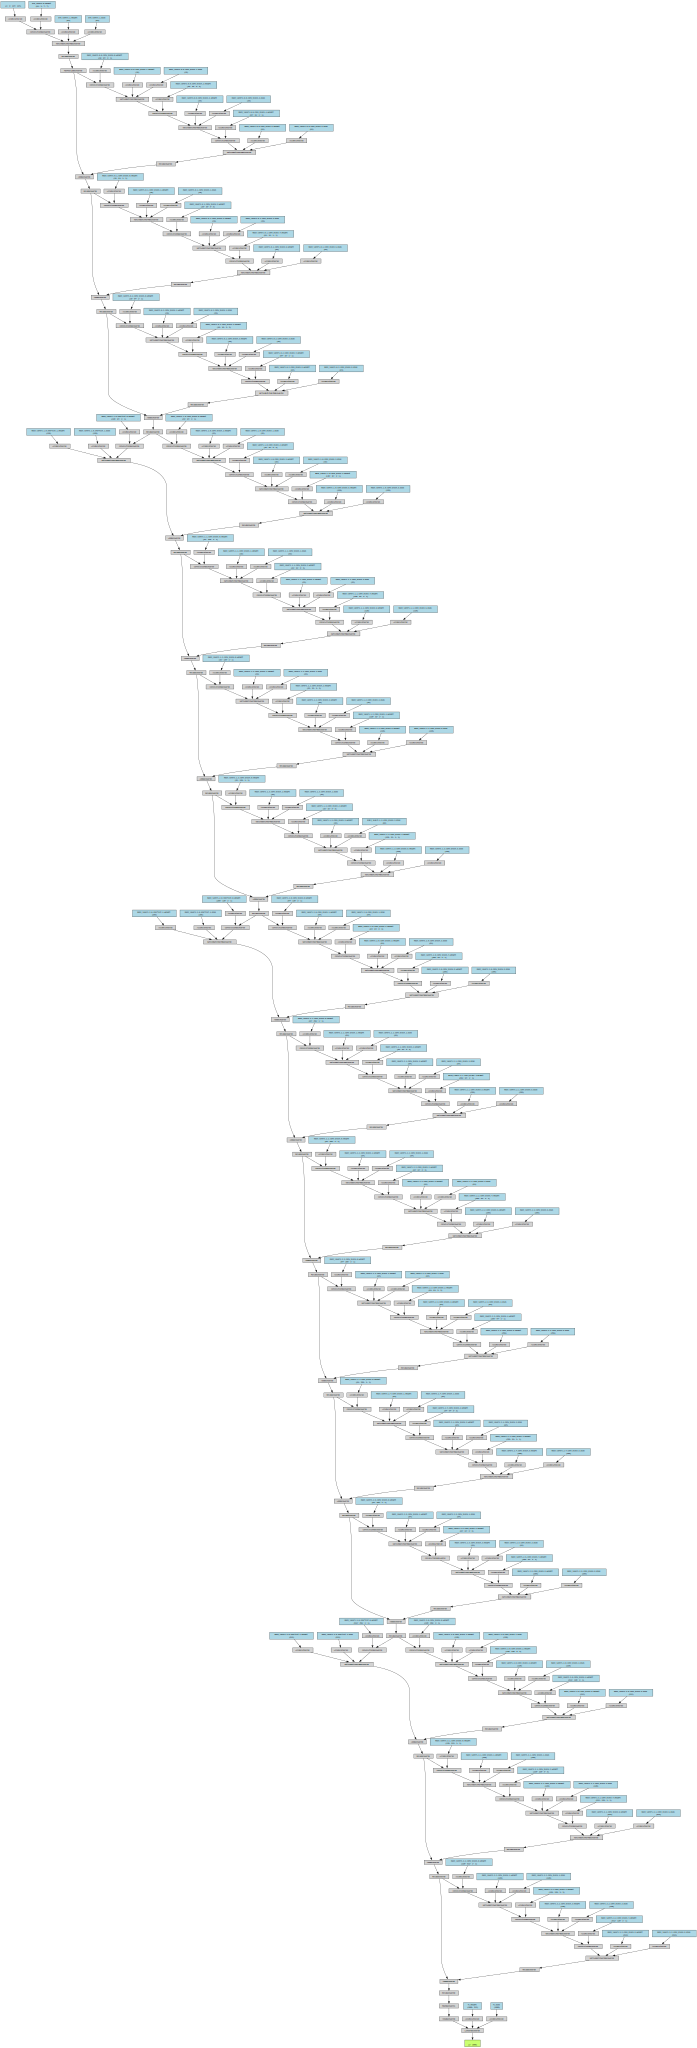

In [9]:
from torchviz import make_dot
import os
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin'  # M1/M2 Mac

x = torch.rand(1, 3, 224, 224).to(device).requires_grad_(True)
model = model.to(device)
y = model(x)
MyConvNetVis = make_dot(y, params=dict(model.named_parameters()))
MyConvNetVis.format = "png"
MyConvNetVis.render("ResNet50Model", format="png")
MyConvNetVis

### 5. Run it!

In [ ]:
model = resnet18()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=0.001)
# utils.trianing_loop(model,loss_fn,optimizer,ImageNet_train_iter,ImageNet_val_iter,15,device)
# 自己跑去，我跑不动